<a href="https://colab.research.google.com/github/blueriver212/CatAnalysis/blob/main/OrbitCollaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install sgp4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.1/232.1 kB 2.1 MB/s eta 0:00:00


In [10]:
import sp3
from astropy.coordinates import GCRS, ITRS
from astropy import units as u
from astropy.time import Time
import numpy as np
np.set_printoptions(precision=15, suppress=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# now we need to propagate with sgp4 each TLE up untill the start of the next one with a timestep size of 30 seconds
import sgp4
from sgp4.api import Satrec, jday
from datetime import datetime
from sgp4.earth_gravity import wgs84
import plotly

In [12]:
product = sp3.Product.from_file("/content/sample_data/GFZOP_RSO_L65_G_20230924_100000_20230925_000000_v03.sp3")

In [34]:
product.satellites[0].records[0]

Record(time=datetime.datetime(2023, 9, 24, 9, 59, 42, tzinfo=datetime.timezone.utc), position=(-893954.2000000001, -163287.197, 6789687.2020000005), position_std=None, velocity=(7541.2079229, 415.39587300000005, 1010.2225334000001), velocity_std=None, clock=0.9999999999989999, clock_std=None, clock_rate=None, clock_rate_std=None, clock_event=False, clock_predicted=False, xy_correlation=None, xz_correlation=None, xc_correlation=None, yz_correlation=None, yc_correlation=None, zc_correlation=None, xy_velocity_correlation=None, xz_velocity_correlation=None, xc_velocity_correlation=None, yz_velocity_correlation=None, yc_velocity_correlation=None, zc_velocity_correlation=None)

In [ ]:
sp3_time = [result.time for result in product.satellites[0].records]
sp3_ephemeris = []

# create an ephemeris array in eci
for item in product.satellites[0].records:
    # Convert to km
    pos_ecef = np.array([item.position[0], item.position[1], item.position[2]])
    epoch = Time(item.time)

    # Set up as ECEF (ITRS)
    itrs = ITRS(
        x=item.position[0] * u.m,
        y=item.position[1] * u.m,
        z=item.position[2] * u.m,
        v_x=item.velocity[0] * u.m/u.s,
        v_y=item.velocity[1] * u.m/u.s,
        v_z=item.velocity[2] * u.m/u.s,
        representation_type='cartesian',
        differential_type='cartesian',
        obstime=epoch
    )

    gcrs = itrs.transform_to(GCRS(obstime=epoch))
    pos = np.array([gcrs.cartesian.x.value, gcrs.cartesian.y.value, gcrs.cartesian.z.value])
    vel = np.array([gcrs.velocity.d_x.value, gcrs.velocity.d_y.value, gcrs.velocity.d_z.value])
    cross_track = np.cross(pos, vel)
    long_track = np.cross(pos, cross_track)
    sp3_ephemeris.append({
        'time': item.time,
        'position': pos,
        'velocity': vel,
        'cross_track': cross_track,
        'long_track': long_track
    })

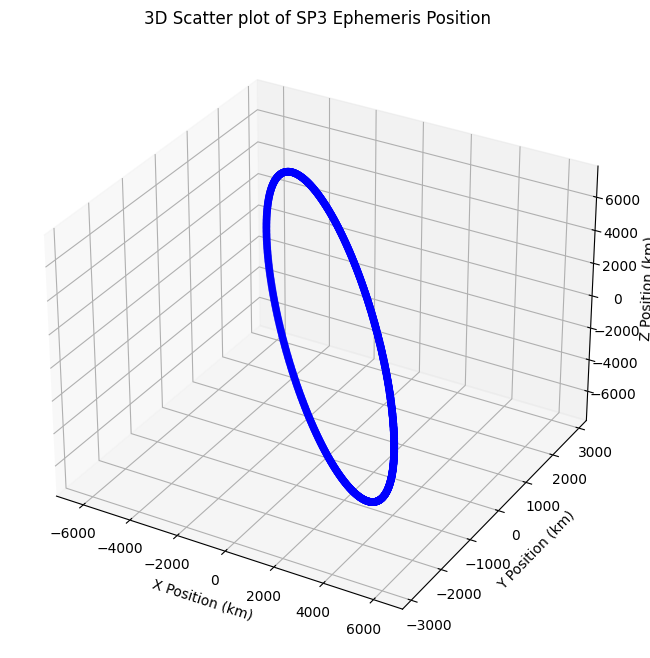

In [15]:
x = [entry['position'][0] for entry in sp3_ephemeris]
y = [entry['position'][1] for entry in sp3_ephemeris]
z = [entry['position'][2] for entry in sp3_ephemeris]

# Create a new figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Setting labels
ax.set_xlabel('X Position (km)')
ax.set_ylabel('Y Position (km)')
ax.set_zlabel('Z Position (km)')
ax.set_title('3D Scatter plot of SP3 Ephemeris Position')

# Show the plot
plt.show()

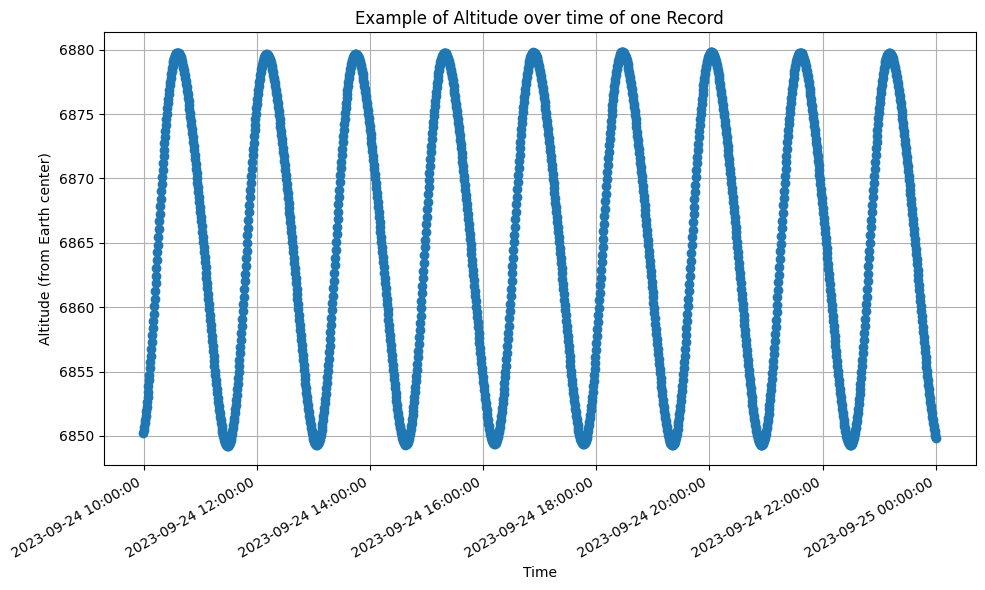

In [16]:
sp3_altitude = [np.linalg.norm(item['position']) for item in sp3_ephemeris]

plt.figure(figsize=(10, 6))
plt.plot(sp3_time, sp3_altitude, marker='o')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # for slanting date labels
plt.xlabel('Time')
plt.ylabel('Altitude (from Earth center)')
plt.title('Example of Altitude over time of one Record')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
## look at the epoch ranges for grace-fo-1
# load the tle json
import json
from datetime import datetime, timedelta
from dateutil.tz import tzutc

with open('/content/sample_data/grace-fo-1-tle-43476.json', "r") as file:
    tle_raw = json.load(file)

# get the datetime of the period that we are interested in
start_time = product.satellites[0].records[0].time
end_time = product.satellites[0].records[-1].time
start_time_range = start_time - timedelta(days=1)
end_time_range = start_time + timedelta(days=2)

tles = [entry for entry in tle_raw if start_time_range <= datetime.fromisoformat(entry['EPOCH']).replace(tzinfo=tzutc()) <= end_time_range]
tles

[{'COMMENT': 'GENERATED VIA SPACETRACK.ORG API',
  'ORIGINATOR': '18 SPCS',
  'NORAD_CAT_ID': '43476',
  'OBJECT_NAME': 'TBA - TO BE ASSIGNED',
  'OBJECT_TYPE': 'UNKNOWN',
  'CLASSIFICATION_TYPE': 'U',
  'INTLDES': '18047A',
  'EPOCH': '2023-09-23 11:36:26',
  'EPOCH_MICROSECONDS': '968608',
  'MEAN_MOTION': '15.26850868',
  'ECCENTRICITY': '0.0014899',
  'INCLINATION': '88.9899',
  'RA_OF_ASC_NODE': '335.8238',
  'ARG_OF_PERICENTER': '30.2811',
  'MEAN_ANOMALY': '329.9296',
  'EPHEMERIS_TYPE': '0',
  'ELEMENT_SET_NO': '999',
  'REV_AT_EPOCH': '29699',
  'BSTAR': '0.00015877',
  'MEAN_MOTION_DOT': '0.00004227',
  'MEAN_MOTION_DDOT': '0',
  'FILE': '4014315',
  'TLE_LINE0': '0 TBA - TO BE ASSIGNED',
  'TLE_LINE1': '1 43476U 18047A   23266.48364547  .00004227  00000-0  15877-3 0  9990',
  'TLE_LINE2': '2 43476  88.9899 335.8238 0014899  30.2811 329.9296 15.26850868296999',
  'OBJECT_ID': '2018-047A',
  'OBJECT_NUMBER': '43476',
  'SEMIMAJOR_AXIS': '6863.370',
  'PERIOD': '94.312',
  'APO

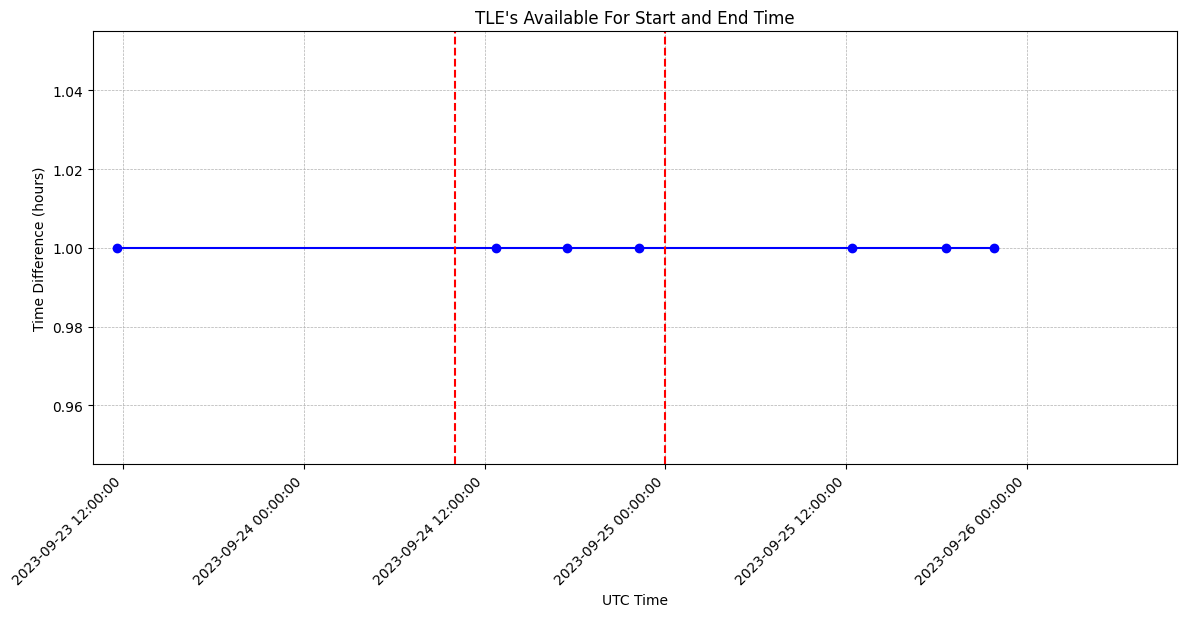

In [19]:
epoch_times = [datetime.fromisoformat(entry['EPOCH']) for entry in tles]

# Calculate time differences in hours
time_diffs = [1 for _ in epoch_times]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, time_diffs, marker='o', linestyle='-', color='blue')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # for slanting date labels
plt.title("TLE's Available For Start and End Time")
plt.xlabel("UTC Time")
plt.ylabel("Time Difference (hours)")
plt.axvline(start_time, color='red', linestyle='--', label='Start Time')
plt.axvline(end_time, color='red', linestyle='--', label='End Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlim(start_time_range, end_time_range)
plt.show()

In [20]:
tle_ephemeris = []
sp3_timesteps = sp3_time

# Propagate using the most up to date TLE, here the time is to go backwards through the tle list
for _sp3_time in sp3_time:
    most_recent_tle = None
    for tle in reversed(tles):
        tle_time = datetime.strptime(tle['EPOCH'], '%Y-%m-%d %H:%M:%S').replace(tzinfo=tzutc())
        if tle_time <= _sp3_time:
            most_recent_tle = tle
            break

    if not most_recent_tle:
        # Handle case where no valid TLE is found for _sp3_time
        continue

    # Propagate using SGP4 for that specific timestep with the found TLE:
    satellite = Satrec.twoline2rv(most_recent_tle['TLE_LINE1'], most_recent_tle['TLE_LINE2'])
    jd, fr = jday(_sp3_time.year, _sp3_time.month, _sp3_time.day, _sp3_time.hour, _sp3_time.minute, _sp3_time.second)
    e, r, v = satellite.sgp4(jd, fr)

    # Store the result in the ephemeris list:
    tle_ephemeris.append({
        'time': _sp3_time,
        'position': r,
        'velocity': v
    })

In [21]:
# Calculate altitudes and extract times
tle_times = [entry['time'] for entry in tle_ephemeris]
tle_altitudes = [np.linalg.norm(entry['position']) for entry in tle_ephemeris]

# Plot
import plotly.graph_objects as go

# Assuming you've already calculated the sp3_altitude list and tle_altitudes list
# and you have the sp3_time and tle_times lists ready.

# Create the scatter plot
fig = go.Figure()

# Add SP3 altitude data
fig.add_trace(go.Scatter(x=sp3_time, y=sp3_altitude, mode='lines+markers',
                         name='SP3 Altitude', line=dict(color='blue')))

# Add TLE altitude data
fig.add_trace(go.Scatter(x=tle_times, y=tle_altitudes, mode='lines+markers',
                         name='TLE Altitude', line=dict(color='red')))

# Add vertical lines for start_time and end_time
fig.add_shape(
    go.layout.Shape(type="line", x0=start_time, x1=start_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="Start Time")
)
fig.add_shape(
    go.layout.Shape(type="line", x0=end_time, x1=end_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="End Time")
)

# Setting labels, title and layout
fig.update_layout(title='Altitude over Time',
                  xaxis_title='Time',
                  yaxis_title='Altitude (km)',
                  xaxis=dict(showgrid=True, showline=True, showticklabels=True, tickangle=45),
                  yaxis=dict(showgrid=True, showline=True, showticklabels=True),
                  showlegend=True)

# Show the interactive plot
fig.show()


In [22]:
sp3_ephemeris[0]
tle_ephemeris[0]

{'time': datetime.datetime(2023, 9, 24, 9, 59, 42, tzinfo=datetime.timezone.utc),
 'position': (688.3515478840168, -178.93930063309708, 6813.405695399591),
 'velocity': (-6.909212175114892, 3.1352682894201553, 0.7884096422189287)}

In [23]:
#cross track is the cross product of the altitude and the velocity
for entry in tle_ephemeris:
  entry['cross_track'] = np.cross(entry['position'], entry['velocity'])
  entry['long_track'] = np.cross(entry['position'], entry['cross_track'])

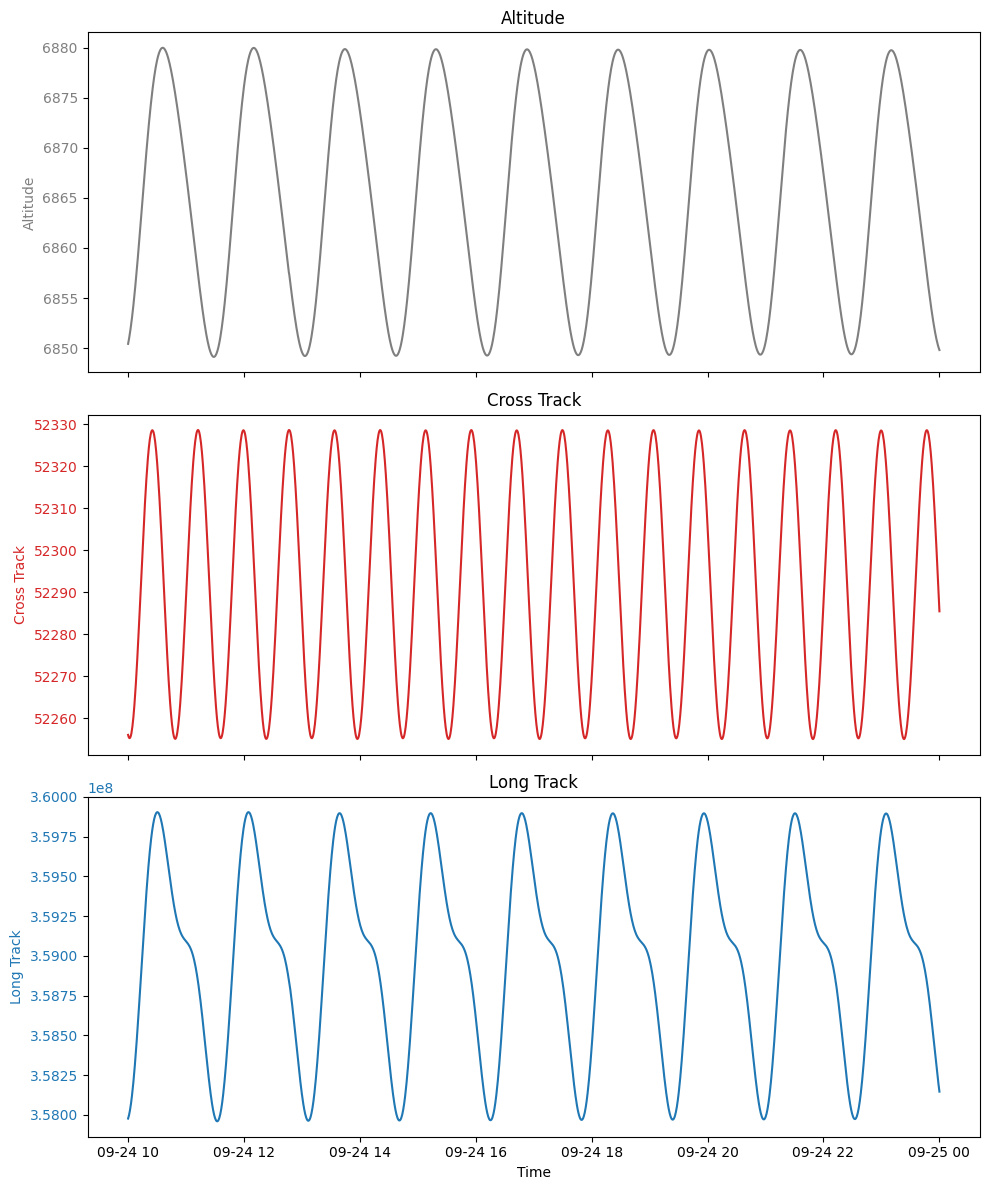

In [24]:
times = [entry['time'] for entry in tle_ephemeris]
tle_altitudes = [np.linalg.norm(entry['position']) for entry in tle_ephemeris]
tle_cross_track_values = [entry['cross_track'] for entry in tle_ephemeris]
tle_long_track_values = [entry['long_track'] for entry in tle_ephemeris]

tle_cross_track_values_norm = [np.linalg.norm(i) for i in tle_cross_track_values]
tle_long_track_norm = [np.linalg.norm(i) for i in tle_long_track_values]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

color = 'tab:grey'
ax1.set_ylabel('Altitude', color=color)
ax1.plot(times, tle_altitudes, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Altitude")

# Plot for Cross Track
color = 'tab:red'
ax2.set_ylabel('Cross Track', color=color)
ax2.plot(times, tle_cross_track_values_norm, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title("Cross Track")

# Plot for Long Track
color = 'tab:blue'
ax3.set_xlabel('Time')
ax3.set_ylabel('Long Track', color=color)
ax3.plot(times, tle_long_track_norm, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_title("Long Track")

fig.tight_layout()  # to ensure adequate spacing between plots
plt.show()


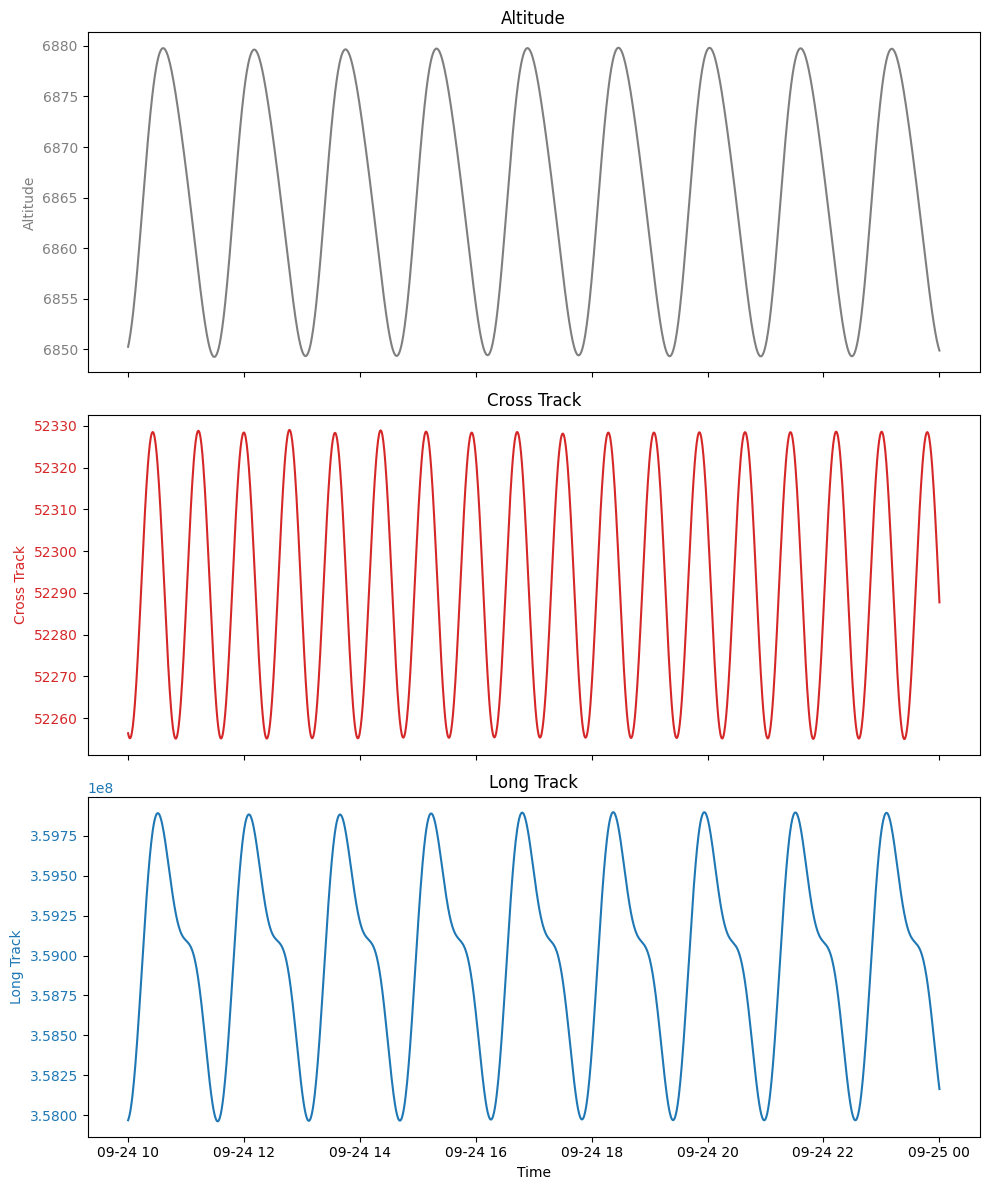

In [25]:
times = [entry['time'] for entry in sp3_ephemeris]
sp3_altitudes = [np.linalg.norm(entry['position']) for entry in sp3_ephemeris]
sp3_cross_track_values = [entry['cross_track'] for entry in sp3_ephemeris]
sp3_long_track_values = [entry['long_track'] for entry in sp3_ephemeris]

sp3_cross_track_norm = [np.linalg.norm(i) for i in sp3_cross_track_values]
sp3_long_track_norm = [np.linalg.norm(i) for i in sp3_long_track_values]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

color = 'tab:grey'
ax1.set_ylabel('Altitude', color=color)
ax1.plot(times, sp3_altitudes, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Altitude")

# Plot for Cross Track
color = 'tab:red'
ax2.set_ylabel('Cross Track', color=color)
ax2.plot(times, sp3_cross_track_norm, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title("Cross Track")

# Plot for Long Track
color = 'tab:blue'
ax3.set_xlabel('Time')
ax3.set_ylabel('Long Track', color=color)
ax3.plot(times, sp3_long_track_norm, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_title("Long Track")

fig.tight_layout()  # to ensure adequate spacing between plots
plt.show()


In [29]:
print(tle_altitudes)
print(tle_long_track_values)

[6850.426577731417, 6850.6770554269, 6850.948735379924, 6851.241348571316, 6851.554578604203, 6851.888062038329, 6852.241388886511, 6852.61410327204, 6853.00570424512, 6853.415646755785, 6853.843342780111, 6854.288162595751, 6854.74943620239, 6855.2264548819185, 6855.718472892672, 6856.224709291466, 6856.744349876636, 6857.27654924483, 6857.82043295377, 6858.375099782915, 6858.939624083363, 6859.513058208225, 6860.094435014164, 6860.682770424725, 6861.27706604574, 6861.8763118229535, 6862.479488731892, 6863.0855714898835, 6863.6935312800915, 6864.302338477481, 6864.910965366569, 6865.518388841001, 6866.123593075064, 6866.725572157405, 6867.323332677496, 6867.915896255537, 6868.502302006872, 6869.081608932221, 6869.652898225459, 6870.21527549098, 6870.767872863209, 6871.309851021107, 6871.840401091175, 6872.358746432768, 6872.864144300195, 6873.355887376511, 6873.8333051745, 6874.295765300916, 6874.742674580585, 6875.173480037622, 6875.587669731521, 6875.984773446541, 6876.364363233366,

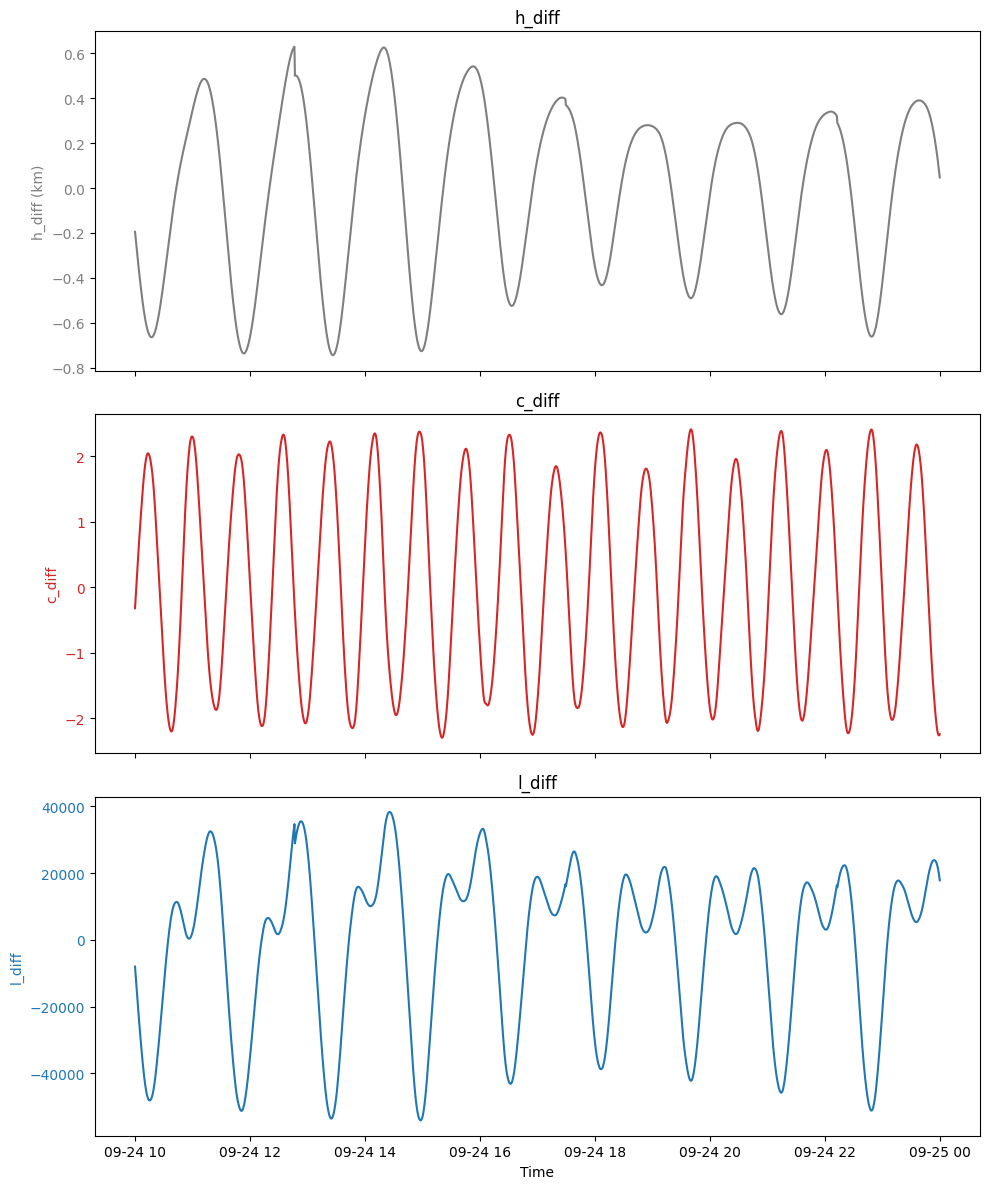

In [32]:
## look at the differences (vector)
h_diff = [a - b for a, b in zip(np.array(sp3_altitudes), np.array(tle_altitudes))]

sp3_cross_track_norm = [np.linalg.norm(i) for i in sp3_cross_track_values]
tle_cross_track_norm = [np.linalg.norm(i) for i in tle_cross_track_values]

sp3_long_track_norm = [np.linalg.norm(i) for i in sp3_long_track_values]
tle_long_track_norm = [np.linalg.norm(i) for i in tle_long_track_values]

c_diff = [a - b for a, b in zip(np.array(tle_cross_track_norm), np.array(sp3_cross_track_norm))]
l_diff = [a - b for a, b in zip(np.array(sp3_long_track_norm), np.array(tle_long_track_norm))]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

color = 'tab:grey'
ax1.set_ylabel('h_diff (km)', color=color)
ax1.plot(times, h_diff, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("h_diff")

# Plot for Cross Track
color = 'tab:red'
ax2.set_ylabel('c_diff', color=color)
ax2.plot(times, c_diff, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title("c_diff")

# Plot for Long Track
color = 'tab:blue'
ax3.set_xlabel('Time')
ax3.set_ylabel('l_diff', color=color)
ax3.plot(times, l_diff, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_title("l_diff")

fig.tight_layout()  # to ensure adequate spacing between plots
plt.show()

In [27]:
import plotly.graph_objects as go

# Your SP3 Ephemeris positions
x_sp3 = [entry['position'][0] for entry in sp3_ephemeris]
y_sp3 = [entry['position'][1] for entry in sp3_ephemeris]
z_sp3 = [entry['position'][2] for entry in sp3_ephemeris]

# Assuming you have another dataset named tle_ephemeris
x_tle = [entry['position'][0] for entry in tle_ephemeris]
y_tle = [entry['position'][1] for entry in tle_ephemeris]
z_tle = [entry['position'][2] for entry in tle_ephemeris]

# Create the plot
fig = go.Figure()

# Add SP3 Ephemeris data
fig.add_trace(go.Scatter3d(x=x_sp3, y=y_sp3, z=z_sp3, mode='markers',
                           marker=dict(size=5, color='blue', opacity=0.5), name='SP3 Ephemeris'))

# Add TLE Ephemeris data
fig.add_trace(go.Scatter3d(x=x_tle, y=y_tle, z=z_tle, mode='markers',
                           marker=dict(size=5, color='red', opacity=0.5), name='TLE Ephemeris'))

# Setting labels and title
fig.update_layout(scene=dict(xaxis_title='X Position (km)',
                             yaxis_title='Y Position (km)',
                             zaxis_title='Z Position (km)'),
                  title='3D Scatter plot of SP3 and TLE Ephemeris Positions')

# Show the interactive plot
fig.show()
